# Setup and Imports

In [83]:
# !pip install LPIPS

In [84]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset  # Make sure to import Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from lpips import LPIPS

# Initialize LPIPS metric
lpips_metric = LPIPS(net='vgg').cuda()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /workplace/zyxu/miniconda3/envs/pix/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


# Data Preprocessing

In [85]:
# Define transformations for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 for faster training
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the CIFAR-10 training set
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# TODO: select 3 categories as training dataset
selected_classes = ['airplane', 'bird', 'cat']
selected_class_indices = [cifar10_train.class_to_idx[c] for c in selected_classes]

# Collect 100 images for each class
subset_indices = []
class_counts = {index: 0 for index in selected_class_indices}

for idx, (image, label) in enumerate(cifar10_train):
    if label in selected_class_indices and class_counts[label] < 100:
        subset_indices.append(idx)
        class_counts[label] += 1
    if all(count >= 100 for count in class_counts.values()):
        break

# Create a subset for training
cifar10_subset = Subset(cifar10_train, subset_indices)
train_loader = DataLoader(cifar10_subset, batch_size=4, shuffle=True)

# Define the Generator and Discriminator

In [86]:
class ConvBlock(nn.Module):
    """Down-sampling block used by both generator and discriminator."""
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 activation=True, batch_norm=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.activation = activation
        self.batch_norm = batch_norm
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else None

    def forward(self, x):
        out = self.conv(self.lrelu(x) if self.activation else x)
        if self.batch_norm:
            out = self.bn(out)
        return out


class DeconvBlock(nn.Module):
    """Up-sampling block with optional dropout for the decoder path."""
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1,
                 batch_norm=True, dropout=False):
        super().__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.bn = nn.BatchNorm2d(out_channels) if batch_norm else None
        self.drop = nn.Dropout(0.5) if dropout else None
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.deconv(self.relu(x))
        if self.batch_norm:
            out = self.bn(out)
        if self.dropout:
            out = self.drop(out)
        return out


class UNetGenerator(nn.Module):
    def __init__(self, input_dim=3, base_filter=64, output_dim=3):
        super().__init__()
        # TODO: define a UNet-like generator
        # Encoder
        self.enc1 = ConvBlock(input_dim, base_filter, activation=False, batch_norm=False)
        self.enc2 = ConvBlock(base_filter, base_filter * 2)
        self.enc3 = ConvBlock(base_filter * 2, base_filter * 4)
        self.enc4 = ConvBlock(base_filter * 4, base_filter * 8)
        self.enc5 = ConvBlock(base_filter * 8, base_filter * 8)
        self.enc6 = ConvBlock(base_filter * 8, base_filter * 8, batch_norm=False)
        # Decoder
        self.dec1 = DeconvBlock(base_filter * 8, base_filter * 8, dropout=True)
        self.dec2 = DeconvBlock(base_filter * 8 * 2, base_filter * 8, dropout=True)
        self.dec3 = DeconvBlock(base_filter * 8 * 2, base_filter * 4)
        self.dec4 = DeconvBlock(base_filter * 4 * 2, base_filter * 2)
        self.dec5 = DeconvBlock(base_filter * 2 * 2, base_filter)
        self.dec6 = DeconvBlock(base_filter * 2, output_dim, batch_norm=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)

        d1 = self.dec1(e6)
        d1 = torch.cat([d1, e5], dim=1)
        d2 = self.dec2(d1)
        d2 = torch.cat([d2, e4], dim=1)
        d3 = self.dec3(d2)
        d3 = torch.cat([d3, e3], dim=1)
        d4 = self.dec4(d3)
        d4 = torch.cat([d4, e2], dim=1)
        d5 = self.dec5(d4)
        d5 = torch.cat([d5, e1], dim=1)
        d6 = self.dec6(d5)
        return self.tanh(d6)

    def normal_weight_init(self, mean=0.0, std=0.02):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.normal_(module.weight, mean, std)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)


class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_dim=6, base_filter=64, output_dim=1):
        super().__init__()
        # TODO: define a simple PatchGAN discriminator
        self.conv1 = ConvBlock(input_dim, base_filter, activation=False, batch_norm=False)
        self.conv2 = ConvBlock(base_filter, base_filter * 2)
        self.conv3 = ConvBlock(base_filter * 2, base_filter * 4)
        self.conv4 = ConvBlock(base_filter * 4, base_filter * 8, stride=1)
        self.conv5 = ConvBlock(base_filter * 8, output_dim, stride=1, activation=False, batch_norm=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.conv3(h2)
        h4 = self.conv4(h3)
        return self.sigmoid(self.conv5(h4))

    def normal_weight_init(self, mean=0.0, std=0.02):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, mean, std)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)


# Model Training

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)

# 參考 Pix2Pix 的設定，使用 Sigmoid + BCELoss + L1 損失
criterion_GAN = nn.BCELoss()
criterion_L1 = nn.L1Loss()

lambda_L1 = 100.0 # L1 損失的權重

optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=3e-5, betas=(0.5, 0.999))

g_gan_epoch_history = []
d_epoch_history = []
g_l1_epoch_history = []


def train(num_epochs=350):
    global g_gan_epoch_history, d_epoch_history, g_l1_epoch_history
    g_gan_epoch_history, d_epoch_history, g_l1_epoch_history = [], [], []

    generator.train()
    discriminator.train()

    for epoch in range(num_epochs):
        epoch_d_losses = []
        epoch_g_adv_losses = []
        epoch_g_l1_losses = []

        for step, (input_img, _) in enumerate(train_loader, start=1):
            input_img = input_img.to(device)
            target_img = input_img

            # ===== 更新 D =====
            optimizer_D.zero_grad()
            fake_img = generator(input_img).detach()

            real_pair = torch.cat((input_img, target_img), dim=1)
            fake_pair = torch.cat((input_img, fake_img), dim=1)

            pred_real = discriminator(real_pair)
            pred_fake = discriminator(fake_pair)

            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
            loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
            d_loss = 0.5 * (loss_D_real + loss_D_fake)
            d_loss.backward()
            optimizer_D.step()

            # ===== 更新 G =====
            optimizer_G.zero_grad()
            gen_img = generator(input_img)
            fake_pair_for_G = torch.cat((input_img, gen_img), dim=1)
            pred_fake_for_G = discriminator(fake_pair_for_G)

            g_adv_loss = criterion_GAN(pred_fake_for_G, torch.ones_like(pred_fake_for_G))
            g_l1_loss = criterion_L1(gen_img, target_img) * lambda_L1
            g_loss = g_adv_loss + g_l1_loss
            g_loss.backward()
            optimizer_G.step()

            epoch_d_losses.append(d_loss.item())
            epoch_g_adv_losses.append(g_adv_loss.item())
            epoch_g_l1_losses.append(g_l1_loss.item())

            if step % 25 == 0:
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}] Step [{step}/{len(train_loader)}] "
                    f"D: {epoch_d_losses[-1]:.4f} | G_adv: {epoch_g_adv_losses[-1]:.4f} | L1: {epoch_g_l1_losses[-1]:.4f}"
                )

        d_epoch_history.append(float(np.mean(epoch_d_losses)))
        g_gan_epoch_history.append(float(np.mean(epoch_g_adv_losses)))
        g_l1_epoch_history.append(float(np.mean(epoch_g_l1_losses)))

        print(
            f"Epoch [{epoch + 1}/{num_epochs}] "
            f"D: {d_epoch_history[-1]:.4f} | G_adv: {g_gan_epoch_history[-1]:.4f} | L1: {g_l1_epoch_history[-1]:.4f}"
        )


train()


Using device: cuda
Epoch [1/350] Step [25/75] D: 0.6727 | G_adv: 0.7601 | L1: 17.6477
Epoch [1/350] Step [50/75] D: 0.6501 | G_adv: 0.7776 | L1: 14.7941
Epoch [1/350] Step [75/75] D: 0.6569 | G_adv: 0.7219 | L1: 14.0297
Epoch [1/350] D: 0.6697 | G_adv: 0.7708 | L1: 19.8379
Epoch [2/350] Step [25/75] D: 0.6495 | G_adv: 0.7629 | L1: 11.7730
Epoch [2/350] Step [50/75] D: 0.6484 | G_adv: 0.7626 | L1: 11.2563
Epoch [2/350] Step [75/75] D: 0.6592 | G_adv: 0.7525 | L1: 6.4338
Epoch [2/350] D: 0.6615 | G_adv: 0.7761 | L1: 10.1869
Epoch [3/350] Step [25/75] D: 0.6681 | G_adv: 0.8003 | L1: 5.9049
Epoch [3/350] Step [50/75] D: 0.7028 | G_adv: 0.7384 | L1: 8.0187
Epoch [3/350] Step [75/75] D: 0.6548 | G_adv: 0.7778 | L1: 6.2021
Epoch [3/350] D: 0.6651 | G_adv: 0.7790 | L1: 7.8764
Epoch [4/350] Step [25/75] D: 0.5454 | G_adv: 0.9532 | L1: 7.4074
Epoch [4/350] Step [50/75] D: 0.6928 | G_adv: 0.7515 | L1: 6.3306
Epoch [4/350] Step [75/75] D: 0.6945 | G_adv: 0.7204 | L1: 6.2747
Epoch [4/350] D: 0.6732

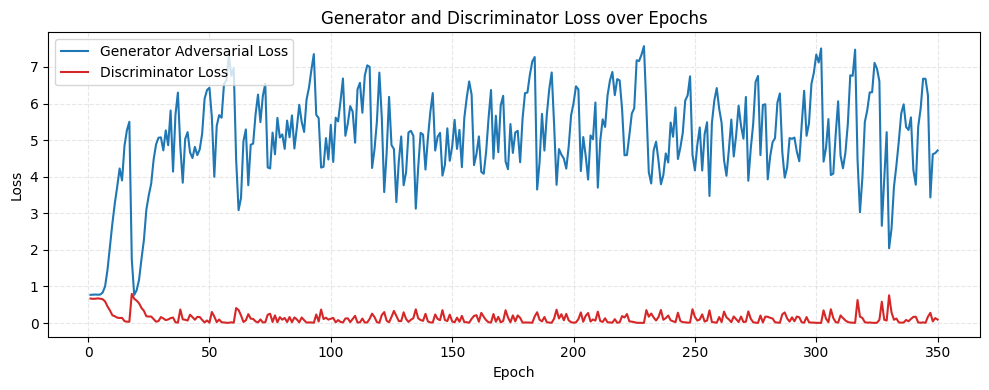

In [ ]:
# TODO: plot Generator and Discriminator loss, Epoch=350
epochs = range(1, len(g_gan_epoch_history) + 1)

plt.figure(figsize=(10, 4))
plt.plot(epochs, g_gan_epoch_history, label='Generator Adversarial Loss', color='tab:blue')
# plt.plot(epochs, g_l1_epoch_history, label='Generator L1 Loss', color='tab:green', linestyle='--')
plt.plot(epochs, d_epoch_history, label='Discriminator Loss', color='tab:red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss over Epochs')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Result

## Quantitative analysis

In [114]:
# TODO: define evaluate function to print evaluation result of PSNR/SSIM/LPIPS
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
from torch.utils.data import DataLoader

def evaluate(num_samples: int = 100):
    """在 cifar10_subset 上評估已訓練好的 Generator。
    預設使用 100 張影像，計算平均 PSNR / SSIM / LPIPS。
    """
    generator.eval()
    psnr_vals = []
    ssim_vals = []
    lpips_vals = []

    eval_loader = DataLoader(cifar10_subset, batch_size=8, shuffle=False)

    processed = 0
    with torch.no_grad():
        for imgs, _ in eval_loader:
            if processed >= num_samples:
                break

            if processed + imgs.size(0) > num_samples:
                imgs = imgs[: num_samples - processed]

            imgs = imgs.to(device)

            input_img = imgs
            target_img = imgs
            fake_img = generator(input_img)

            # [-1, 1] → [0, 1]，轉成 NHWC
            real_np = ((target_img.detach().cpu().numpy() + 1.0) / 2.0)
            fake_np = ((fake_img.detach().cpu().numpy() + 1.0) / 2.0)

            real_np = np.transpose(real_np, (0, 2, 3, 1))  # (N, H, W, C)
            fake_np = np.transpose(fake_np, (0, 2, 3, 1))

            for r, f in zip(real_np, fake_np):
                psnr_vals.append(psnr(r, f, data_range=1.0))
                ssim_vals.append(
                    ssim(r, f, data_range=1.0, channel_axis=-1)
                )

            # LPIPS：輸入依然用 [-1, 1] 的 tensor (N,3,H,W)
            lpips_val = lpips_metric(fake_img, target_img).mean().item()
            lpips_vals.append(lpips_val)

            processed += imgs.size(0)

            if processed >= num_samples:
                break

    mean_psnr = float(np.mean(psnr_vals))
    mean_ssim = float(np.mean(ssim_vals))
    mean_lpips = float(np.mean(lpips_vals))

    print(f"Evaluation on {processed} samples:")
    print(f"  PSNR  : {mean_psnr:.4f}")
    print(f"  SSIM  : {mean_ssim:.4f}")
    print(f"  LPIPS : {mean_lpips:.4f}")


In [ ]:
# Epoch = 350
evaluate()

Evaluation on 100 samples:
  PSNR  : 40.0898
  SSIM  : 0.9843
  LPIPS : 0.0308


## Qualitative analysis

In [116]:
# TODO: define visualization function for Qualitative analysis.
def inference_and_visualize(num_per_class: int = 4):
    """Visualize 4 generator outputs for each selected CIFAR-10 class."""
    generator.eval()

    loader = DataLoader(cifar10_train, batch_size=1, shuffle=True)
    samples_per_class = {cls_idx: [] for cls_idx in selected_class_indices}

    with torch.no_grad():
        for img, label in loader:
            label = int(label.item())
            if label in samples_per_class and len(samples_per_class[label]) < num_per_class:
                img_device = img.to(device)
                fake = generator(img_device)
                samples_per_class[label].append(fake.cpu())

            if all(len(samples_per_class[c]) >= num_per_class for c in selected_class_indices):
                break

    rows = len(selected_classes)
    cols = num_per_class
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = np.atleast_2d(axes)

    for row, (cls_name, cls_idx) in enumerate(zip(selected_classes, selected_class_indices)):
        for col in range(cols):
            ax = axes[row, col]
            ax.axis('off')
            if col >= len(samples_per_class[cls_idx]):
                continue

            fake_img = samples_per_class[cls_idx][col].squeeze(0)
            fake_np = fake_img.permute(1, 2, 0).numpy()
            fake_np = ((fake_np + 1.0) / 2.0).clip(0, 1)

            ax.imshow(fake_np)
            ax.set_title(cls_name, fontsize=9)

    fig.suptitle('Qualitative analysis: 4 samples per class', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


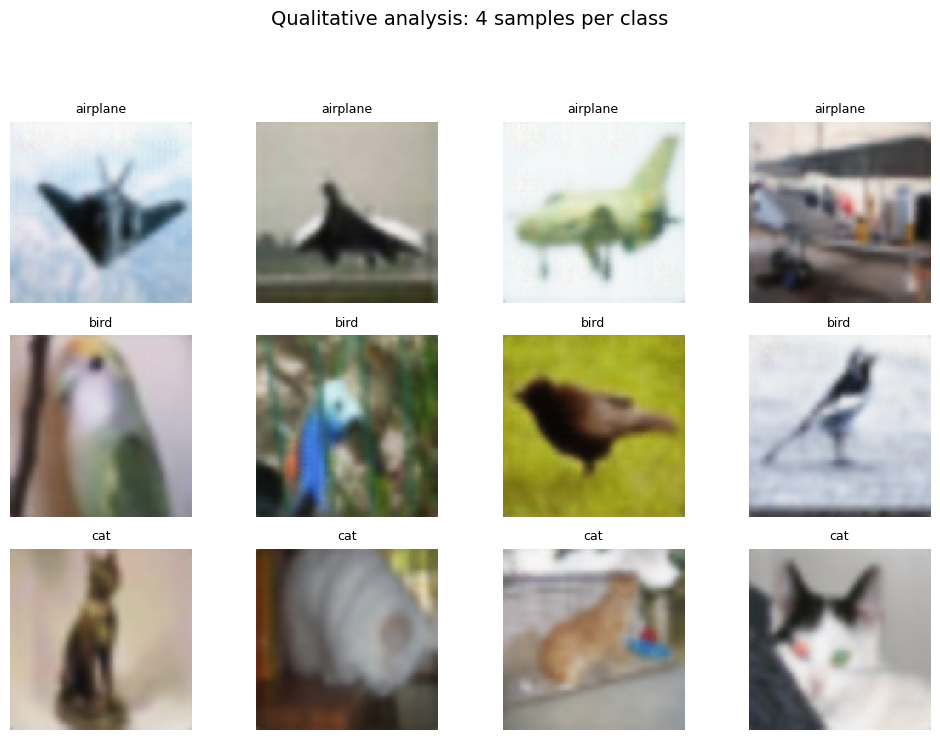

In [ ]:
# Epoch = 350
inference_and_visualize()